## Simple Analysis of Tweet data using Naive Bayes and Random Forest



In [1]:
#imports
import pandas as pd
import numpy as np

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

#### Data Preprocessing:

In [2]:
twt_df  = pd.read_csv('tweet.csv')
twt_df

,sentiment,txt
0,1,I cant sleep. Not good with maths tomorrow. Th...
1,1,bored.. &amp; i hate this taste in my mouth.. ...
2,1,I have to work alllll day today So much for m...
3,1,"@wndllg unfortunately, no. we're going someti..."
4,1,I hate johnny
...,...,...
19995,0,Best i ever had- drake..song of my lifeee righ...
19996,0,Babysitting and then headed to Indiana!!
19997,0,says i'm back from sing sing singapore http:/...
19998,0,i am playing live ( 1 time only? maybe ) at t...


In [3]:
def clean_df_text_field(df, field_name):
    df[field_name] = df[field_name].str.replace(r"http\S+", "_url_")
    df[field_name] = df[field_name].str.replace(r"http", "_url_")
    df[field_name] = df[field_name].str.replace(r"[^A-Za-z0-9(),!?\'\`\"\_\n\@]", " ")
    df[field_name] = df[field_name].str.replace(r"\W*\b\w{15,}\b","")
    df[field_name] = df[field_name].str.replace(r"[0-9]+","#")
    df[field_name] = df[field_name].str.lower()
    df[field_name] = df[field_name].str.replace(r"(?a:^\s+|\s+$)","")
    return df

In [4]:
twt_df.sentiment.value_counts()

1    10000
0    10000
Name: sentiment, dtype: int64

In [5]:
clean_df_text_field(twt_df,"txt").head(20)

,sentiment,txt
0,1,i cant sleep not good with maths tomorrow th...
1,1,bored amp i hate this taste in my mouth ...
2,1,i have to work alllll day today so much for m...
3,1,"@wndllg unfortunately, no we're going someti..."
4,1,i hate johnny
5,1,wishes she could find all of these cool things...
6,1,@mizrik good # hear still waiting on our iho...
7,1,@donniewahlberg this was supposed to be my nig...
8,1,gotta get to work soon tired
9,1,www apple com iphone now has it for the #th


In [6]:
X_train, X_test, y_train, y_test = train_test_split(twt_df.txt,twt_df.sentiment,test_size=0.3)

In [7]:
X_train.iloc[5] ## output example

"(ooc  i guess everyone is off  i'm bummed that there still is no emmett! ughhh  anyways, i'll be on in the am  xoxo)"

#### Pipeline and GridSearch

In [10]:
## Multinomial NB
twt_pipe = Pipeline([("tfidf",TfidfVectorizer()),("nb", MultinomialNB())])
param_grid = [{"tfidf__min_df":[5,10,15,20],
               "tfidf__max_features":[1000,2000,4000],
               'tfidf__stop_words': [None, 'english'],
               "tfidf__ngram_range":[(1, 1), (1, 2), (1, 3), (1, 5)]}]
twt_grid = GridSearchCV(estimator=twt_pipe , param_grid =param_grid, cv=5)
twt_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid=[{'tfidf__max_features': [1000, 2000, 4000],
                          'tfidf__min_df': [5, 10, 15, 20],
                          'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                 (1, 5)],
                          'tfidf__stop_words': [None, 'english']}])

In [11]:
twt_grid.best_params_

{'tfidf__max_features': 4000,
 'tfidf__min_df': 5,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': None}

In [12]:
twt_grid.best_score_

0.7484999999999999

In [13]:
twt_grid.score(X_train, y_train)

0.8137857142857143

In [14]:
twt_grid.score(X_test, y_test)

0.7508333333333334

In [15]:
y_test.value_counts()

0    3011
1    2989
Name: sentiment, dtype: int64

In [16]:
#Random Forest
rf_pipe = Pipeline([("tfidf",TfidfVectorizer()),("rf", RandomForestClassifier())])
rf_param_grid = [{"tfidf__min_df":[1,5,10],
               "tfidf__max_features":[4000,8000,12000],
               'tfidf__stop_words': [None, 'english'],
               "tfidf__ngram_range":[(1,1),(1, 2), (1, 5)],
                "rf__n_estimators":[200,300], "rf__max_depth":[20,50,70]}]
rf_twt_grid = GridSearchCV(estimator=rf_pipe , param_grid =rf_param_grid, cv=4, verbose=5,n_jobs=-1 )
rf_twt_grid.fit(X_train, y_train)

Fitting 4 folds for each of 324 candidates, totalling 1296 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'rf__max_depth': [20, 50, 70],
                          'rf__n_estimators': [200, 300],
                          'tfidf__max_features': [4000, 8000, 12000],
                          'tfidf__min_df': [1, 5, 10],
                          'tfidf__ngram_range': [(1, 1), (1, 2), (1, 5)],
                          'tfidf__stop_words': [None, 'english']}],
             verbose=5)

In [17]:
rf_twt_grid.best_params_

{'rf__max_depth': 50,
 'rf__n_estimators': 300,
 'tfidf__max_features': 12000,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': None}

In [18]:
rf_twt_grid.score(X_train, y_train)

0.9247142857142857

In [19]:
rf_twt_grid.score(X_test, y_test)

0.7363333333333333

#### Classification Report / Confusion Matrix on Test Set

Naive Bayes

In [20]:
print(metrics.classification_report(y_test, twt_grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.73      0.75      3011
           1       0.74      0.77      0.76      2989

    accuracy                           0.75      6000
   macro avg       0.75      0.75      0.75      6000
weighted avg       0.75      0.75      0.75      6000



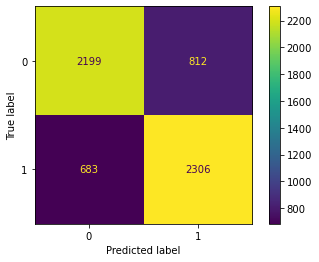

In [21]:
metrics.plot_confusion_matrix(twt_grid, X_test, y_test)

Random Forest

In [22]:
print(metrics.classification_report(y_test, rf_twt_grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      3011
           1       0.74      0.74      0.74      2989

    accuracy                           0.74      6000
   macro avg       0.74      0.74      0.74      6000
weighted avg       0.74      0.74      0.74      6000



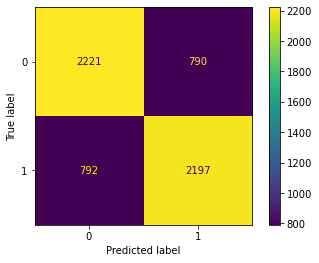

In [23]:
metrics.plot_confusion_matrix(rf_twt_grid, X_test, y_test)